In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('ggplot')

## Задание:
```
Необходимо посчитать результаты A/A-теста мобильного приложения, проверяя метрику качества FPR (доля ложно-положительных срабатываний) для конверсии в покупку. Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.
```

In [ ]:
# Загружаем данные и изучаем их содержимое

dir_path = '~/data_files/'
df = pd.read_csv(dir_path + 'hw_aa.zip', sep=';', compression='zip')
df = df.drop(columns={'Unnamed: 0'})
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [ ]:
df.shape

(127018, 4)

In [ ]:
df.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [ ]:
# Задаем функцию, проводящую симуляции сравнения двух выборок t-тестом

def run_simulations(control, treatment, simulations, n_s):
    res = []
    for i in tqdm(range(simulations)):
        s1 = control.sample(n_s, replace = False).values
        s2 = treatment.sample(n_s, replace = False).values
        p_value = ttest_ind(s1, s2, equal_var = False)[1]
        res.append(p_value) # сохраняем p_value
    return res


In [ ]:
# Разделим пользователей на 2 группы по значению поля experimentVariant;
# условно: 0 - control, 1 - treatment

control = df[df.experimentVariant == 0]
treatment = df[df.experimentVariant == 1]

  0%|          | 0/1000 [00:00<?, ?it/s]

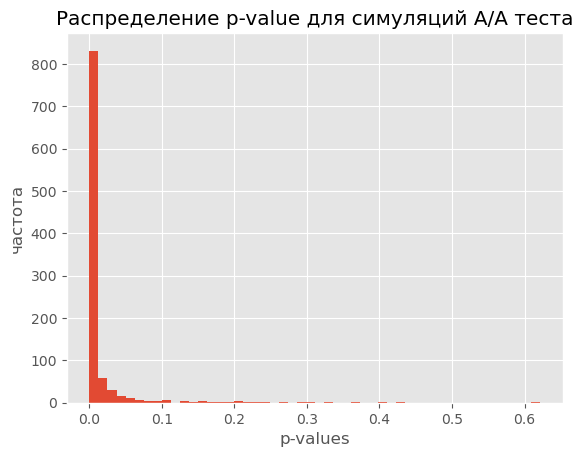

Доля ложно-положительных срабатываний = 0.935


In [ ]:
alpha = 0.05
simulations = 1000
n_s = 1000

# Запуск симуляций A/A-теста
res = run_simulations(control.purchase, treatment.purchase, simulations, n_s)

plt.hist(res, bins = 50)
plt.xlabel('p-values')
plt.ylabel('частота')
plt.title("Распределение p-value для симуляций A/A теста")
plt.show()

# Проверяем, что количество ложно-положительных случаев не превышает установленного порога alpha
print('Доля ложно-положительных срабатываний =', sum(np.array(res) < alpha) / simulations)

Из полученной гистограммы по её скошенности к 0 можно видеть, что А/А-тест работает некорректно.
По доле ложно-положительных срабатываний намного больше 0.05 тоже видно, что А/А-тест работает некорректно. Попробуем сгруппировать пользователей по версиям приложения с целью более детального анализа ошибок в организации проведения эксперимента.

In [ ]:
# За счёт того, что поле purchase является числовым с бинарными значаниями (0 и 1), можно
# использовать среднее в качестве конверсии покупок.

grouped_df = df.groupby(['experimentVariant', 'version'], as_index=False) \
    .agg({'purchase' : 'mean'}) \
    .rename(columns={'purchase' : 'conversion'}).copy()
grouped_df

,experimentVariant,version,conversion
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Можно заметить, что для приложения версии 2.8.0 конверсия в покупку существенно отличается между группами экспермента (хотя значения должны быть примерно одинаковыми). Для проверки на наличие аномалий требуется провести А/А-тесты отдельно для каждой версии приложения.

  0%|          | 0/1000 [00:00<?, ?it/s]

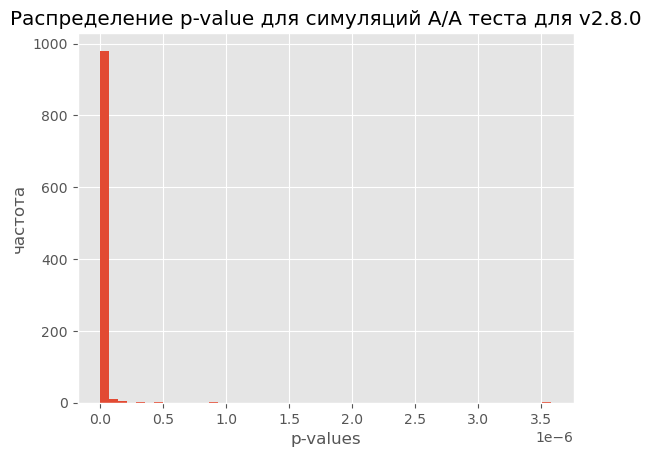

Доля ложно-положительных срабатываний = 1.0


In [ ]:
app_version = 'v2.8.0'

# Запуск симуляций A/A-теста
control_for_app_version = control[control.version == app_version]
treatment_for_app_version = treatment[treatment.version == app_version]
res = run_simulations(control_for_app_version.purchase, treatment_for_app_version.purchase, simulations, n_s)

plt.hist(res, bins = 50)
plt.xlabel('p-values')
plt.ylabel('частота')
plt.title("Распределение p-value для симуляций A/A теста для " + str(app_version))
plt.show()

# Проверяем, что количество ложно-положительных случаев не превышает установленного порога alpha
print('Доля ложно-положительных срабатываний =', sum(np.array(res) < alpha) / simulations)

Для данной версии приложения (v2.8.0) найдена аномалия данных, которая портит результат A/A-теста.
Проверим остальные версии приложения на аномалии.

  0%|          | 0/1000 [00:00<?, ?it/s]

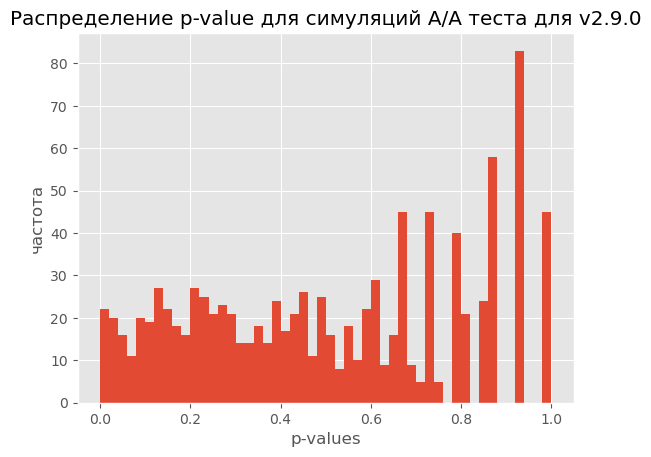

Доля ложно-положительных срабатываний = 0.053


In [ ]:
app_version = 'v2.9.0'

# Запуск симуляций A/A-теста
control_for_app_version = control[control.version == app_version]
treatment_for_app_version = treatment[treatment.version == app_version]
res = run_simulations(control_for_app_version.purchase, treatment_for_app_version.purchase, simulations, n_s)

plt.hist(res, bins = 50)
plt.xlabel('p-values')
plt.ylabel('частота')
plt.title("Распределение p-value для симуляций A/A теста для " + str(app_version))
plt.show()

# Проверяем, что количество ложно-положительных случаев не превышает установленного порога alpha
print('Доля ложно-положительных срабатываний =', sum(np.array(res) < alpha) / simulations)

В случае с версией приложения (v2.9.0) доля ложно-положительных срабатываний слегка превышает допустимый порог в 0.05, однако говорить об однозначной проблеме с этой версией не стоит, ведт возможно нам просто не хватило 1000 симуляций, чтобы получить более близкое к истине значение меньше 0.05. Попробуем для данной версии приложения провести 10000 испытаний.

  0%|          | 0/10000 [00:00<?, ?it/s]

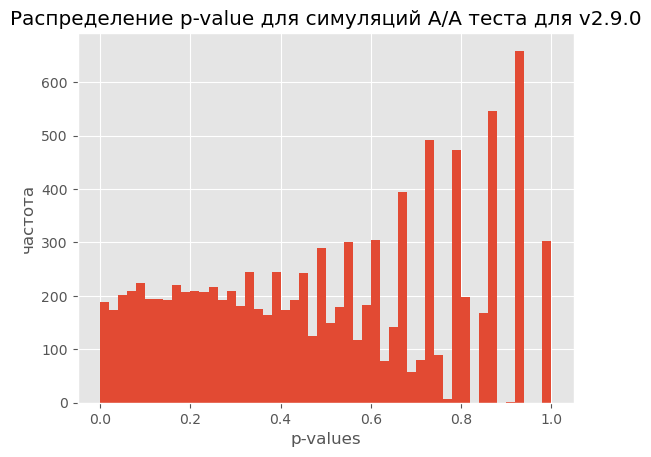

Доля ложно-положительных срабатываний = 0.0462


In [ ]:
app_version = 'v2.9.0'
simulations = 10000

# Запуск симуляций A/A-теста
control_for_app_version = control[control.version == app_version]
treatment_for_app_version = treatment[treatment.version == app_version]
res = run_simulations(control_for_app_version.purchase, treatment_for_app_version.purchase, simulations, n_s)

plt.hist(res, bins = 50)
plt.xlabel('p-values')
plt.ylabel('частота')
plt.title("Распределение p-value для симуляций A/A теста для " + str(app_version))
plt.show()

# Проверяем, что количество ложно-положительных случаев не превышает установленного порога alpha
print('Доля ложно-положительных срабатываний =', sum(np.array(res) < alpha) / simulations)

Как я и предполагал, при приближении к истинному значению благодаря увеличению числа симуляций, мы получили результат меньше порога в 0.05, что свидетельствует об отсутствии проблем с версией приложения (v2.9.0) с большой вероятностью. Впрочем, данная версия приложения остаётся слегка подозрительной, и рекомендуется обратить на неё внимание.

  0%|          | 0/1000 [00:00<?, ?it/s]

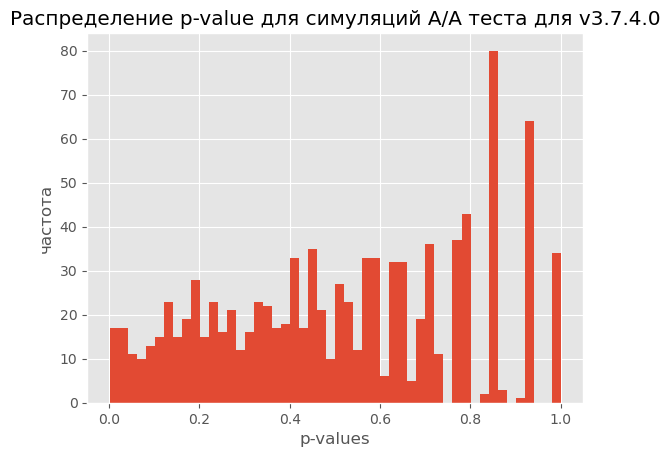

Доля ложно-положительных срабатываний = 0.035


In [ ]:
app_version = 'v3.7.4.0'
simulations = 1000

# Запуск симуляций A/A-теста
control_for_app_version = control[control.version == app_version]
treatment_for_app_version = treatment[treatment.version == app_version]
res = run_simulations(control_for_app_version.purchase, treatment_for_app_version.purchase, simulations, n_s)

plt.hist(res, bins = 50)
plt.xlabel('p-values')
plt.ylabel('частота')
plt.title("Распределение p-value для симуляций A/A теста для " + str(app_version))
plt.show()

# Проверяем, что количество ложно-положительных случаев не превышает установленного порога alpha
print('Доля ложно-положительных срабатываний =', sum(np.array(res) < alpha) / simulations)

  0%|          | 0/1000 [00:00<?, ?it/s]

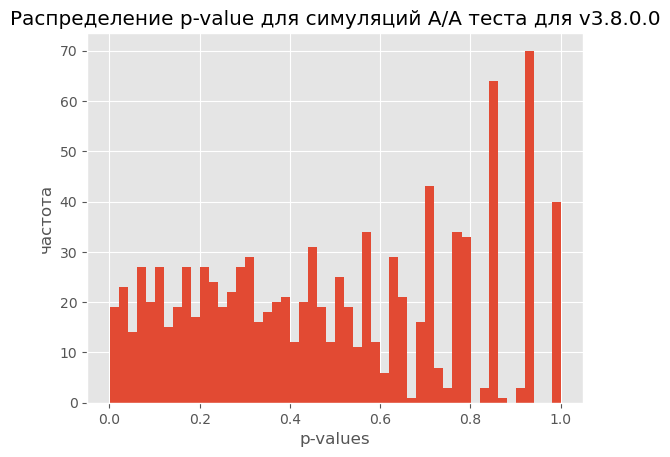

Доля ложно-положительных срабатываний = 0.049


In [ ]:
app_version = 'v3.8.0.0'

# Запуск симуляций A/A-теста
control_for_app_version = control[control.version == app_version]
treatment_for_app_version = treatment[treatment.version == app_version]
res = run_simulations(control_for_app_version.purchase, treatment_for_app_version.purchase, simulations, n_s)

plt.hist(res, bins = 50)
plt.xlabel('p-values')
plt.ylabel('частота')
plt.title("Распределение p-value для симуляций A/A теста для " + str(app_version))
plt.show()

# Проверяем, что количество ложно-положительных случаев не превышает установленного порога alpha
print('Доля ложно-положительных срабатываний =', sum(np.array(res) < alpha) / simulations)

Как можно наблюдать по данным экспериментов для 3 других версий приложения, аномалии в них отсутствуют, что позволяет найти решение для проведения успешного A/A-теста - надо исключить пользователей, пользующихся приложением с версией v2.8.0, а остальные группы включить в итоговый эксперимент.

  0%|          | 0/1000 [00:00<?, ?it/s]

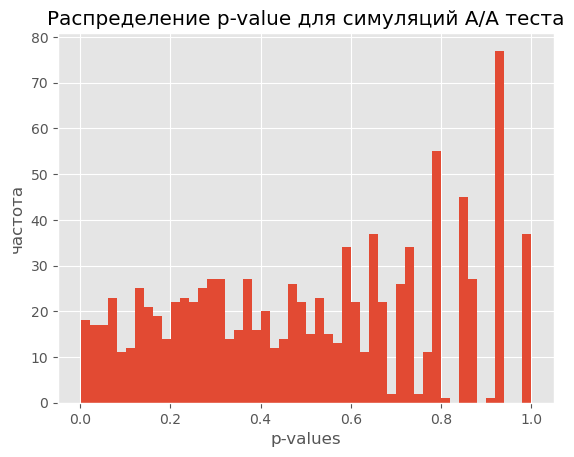

Доля ложно-положительных срабатываний = 0.047


In [ ]:
bad_app_versions = ['v2.8.0']

# Запуск симуляций A/A теста
control_for_app_version = control.query('version not in @bad_app_versions')
treatment_for_app_version = treatment.query('version not in @bad_app_versions')
res = run_simulations(control_for_app_version.purchase, treatment_for_app_version.purchase, simulations, n_s)

plt.hist(res, bins = 50)
plt.xlabel('p-values')
plt.ylabel('частота')
plt.title("Распределение p-value для симуляций A/A теста")
plt.show()

# Проверяем, что количество ложно-положительных случаев не превышает установленного порога alpha
print('Доля ложно-положительных срабатываний =', sum(np.array(res) < alpha) / simulations)

Результаты итогового эксперимента подтвердили, что источником аномалий A/A-теста являются пользователи, пользующиеся приложением с версией v2.8.0, в связи с чем можно сделать вывод о том, что сплит-система действительно сломана и решение надо искать в работе приложения для версии v2.8.0. Что касается версии v2.9.0, то её также следует изучить на наличие ошибок в сплитовании в связи с некоторой неоднозначностью при первой попытке симуляции.